# Sentimen Analisis Review Duolingo pada Play Store


## Import Library

In [1]:
# Manipulasi dan analisis data
import pandas as pd
import numpy as np

# Visualisasi data
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Preprocessing teks
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

!pip install sastrawi --quiet
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

!pip install gensim --quiet
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import re
import string

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Data loading

In [2]:
from google.colab import files

# Upload file ke Colab
uploaded = files.upload()

# Load dataset ke dalam DataFrame
df = pd.read_csv("reviews_playstore_com.duolingo_15000.csv")

# Menampilkan dimensi data
print(f"Jumlah data: {df.shape[0]} baris, {df.shape[1]} kolom")

Saving reviews_playstore_com.duolingo_15000.csv to reviews_playstore_com.duolingo_15000.csv
Jumlah data: 15000 baris, 4 kolom


In [3]:
df.head()

,userName,rating,date,comment
0,Pengguna Google,5,2025-09-27 03:14:59,aku lagi belajar bahasa jepang dan metode bela...
1,Pengguna Google,5,2025-09-27 03:14:35,"kenapa icon nya sedih min, padahal kan bagus a..."
2,Pengguna Google,5,2025-09-27 03:13:54,sangat menyenangkan
3,Pengguna Google,5,2025-09-27 03:12:14,bagus bangett dan asikk dan gampang buat orang...
4,Pengguna Google,5,2025-09-27 03:10:06,bagus untuk belajar bahasa dan musik juga mate...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   userName  15000 non-null  object
 1   rating    15000 non-null  int64 
 2   date      15000 non-null  object
 3   comment   15000 non-null  object
dtypes: int64(1), object(3)
memory usage: 468.9+ KB


## Data Cleaning

In [5]:
# Menghapus kolom 'userName' yang tidak relevan
print("--- Menghapus Kolom userName ---")
df_cleaned = df.drop(columns=['userName'])
print("Kolom 'userName' berhasil dihapus.")
print(f"Dimensi data sekarang: {df_cleaned.shape[0]} baris, {df_cleaned.shape[1]} kolom")

--- Menghapus Kolom userName ---
Kolom 'userName' berhasil dihapus.
Dimensi data sekarang: 15000 baris, 3 kolom


In [6]:
# Mengecek nilai kosong (missing values)
print("--- Pengecekan Nilai Kosong ---")
print("Jumlah nilai kosong di setiap kolom:")
missing_values = df_cleaned.isnull().sum()
print(missing_values)

--- Pengecekan Nilai Kosong ---
Jumlah nilai kosong di setiap kolom:
rating     0
date       0
comment    0
dtype: int64


In [7]:
# Mengecek data duplikat
print("--- Pengecekan Data Duplikat ---")
# Cek duplikat berdasarkan semua kolom yang tersisa
total_duplicates = df_cleaned.duplicated().sum()
print(f"Jumlah baris data yang duplikat (identik di semua kolom): {total_duplicates}")

--- Pengecekan Data Duplikat ---
Jumlah baris data yang duplikat (identik di semua kolom): 0


In [8]:
# Cek duplikat spesifik pada kolom 'comment'
comment_duplicates = df_cleaned.duplicated(subset=['comment']).sum()
print(f"Jumlah ulasan (comment) yang isinya sama persis: {comment_duplicates}")

Jumlah ulasan (comment) yang isinya sama persis: 2697


In [9]:
# Menampilkan jumlah baris sebelum menghapus duplikat ulasan
print(f"Jumlah baris sebelum menghapus duplikat comment: {df_cleaned.shape[0]}")

# Menghapus baris dengan ulasan (comment) yang duplikat
df_cleaned.drop_duplicates(subset=['comment'], keep='first', inplace=True)

# Menampilkan jumlah baris setelah menghapus duplikat ulasan
print(f"Jumlah baris setelah menghapus duplikat comment: {df_cleaned.shape[0]}")


Jumlah baris sebelum menghapus duplikat comment: 15000
Jumlah baris setelah menghapus duplikat comment: 12303


## Prepocessing

In [10]:

import re
import string

# Inisialisasi Stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Inisialisasi Stopwords
list_stopwords = set(stopwords.words('indonesian'))
list_stopwords.update(stopwords.words('english'))
# Menambahkan stopwords custom
custom_stopwords = {'iya','yaa','gak','nya','na','sih','ku',"di","ga","ya",
                    "gaa","loh","kah","woi","woii","woy", 'yg', 'jg', 'dl', 'sm', 'aja', 'spt'}
list_stopwords.update(custom_stopwords)

def cleaningText(text):
    # Menghapus @, #, RT, URL
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#[A-Za-z0-9]+', '', text)
    text = re.sub(r'RT[\s]', '', text)
    text = re.sub(r"http\S+", '', text)
    # Menghapus angka
    text = re.sub(r'[0-9]+', '', text)
    # Menghapus tanda baca
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Menghapus spasi berlebih
    text = text.strip()
    return text

def casefoldingText(text):
    return text.lower()

In [11]:

# Membuat Pipeline Preprocessing

def preprocess_text(text):
    # Cleaning
    text = cleaningText(text)
    # Case folding
    text = casefoldingText(text)
    # Tokenizing
    tokens = word_tokenize(text)
    # Stopword filtering
    tokens = [word for word in tokens if word not in list_stopwords]
    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]
    # Kembali ke kalimat
    return ' '.join(stemmed_tokens)

# Terapkan fungsi preprocess_text ke kolom 'comment'
# Buat kolom baru 'comment_cleaned' untuk menyimpan hasilnya
df_cleaned['comment_cleaned'] = df_cleaned['comment'].apply(preprocess_text)

print("Text preprocessing selesai!")

Text preprocessing selesai!


In [12]:
# Tampilkan kolom asli dan kolom hasil preprocessing untuk perbandingan
print("\nContoh hasil preprocessing:")
print(df_cleaned[['comment', 'comment_cleaned']].head())

# Cek apakah ada baris yang kosong setelah preprocessing (akibat semua kata dihapus)
empty_rows = df_cleaned[df_cleaned['comment_cleaned'] == ''].shape[0]
print(f"\nJumlah ulasan yang menjadi kosong setelah dibersihkan: {empty_rows}")


Contoh hasil preprocessing:
                                             comment  \
0  aku lagi belajar bahasa jepang dan metode bela...   
1  kenapa icon nya sedih min, padahal kan bagus a...   
2                                sangat menyenangkan   
3  bagus bangett dan asikk dan gampang buat orang...   
4  bagus untuk belajar bahasa dan musik juga mate...   

                                     comment_cleaned  
0  ajar bahasa jepang metode ajar enak hiragana s...  
1                       icon sedih min bagus apk nya  
2                                             senang  
3  bagus bangett asikk gampang orang ajar bahasa ...  
4                bagus ajar bahasa musik matematika   

Jumlah ulasan yang menjadi kosong setelah dibersihkan: 112


In [13]:
# Menghapus baris di mana 'comment_cleaned' adalah string kosong
# Replace string kosong ('') dengan NaN (Not a Number) lalu menggunakan dropna()
df_cleaned['comment_cleaned'].replace('', np.nan, inplace=True)
df_cleaned.dropna(subset=['comment_cleaned'], inplace=True)

# Menampilkan jumlah baris setelah dibersihkan
print(f"Jumlah baris setelah menghapus ulasan kosong: {df_cleaned.shape[0]}")

Jumlah baris setelah menghapus ulasan kosong: 12191


/tmp/ipython-input-3681158089.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cleaned['comment_cleaned'].replace('', np.nan, inplace=True)


## Pelabelan


In [14]:
# Kode untuk mengambil lexicon (sama seperti yang Anda punya)
import csv
import requests
from io import StringIO

# Membaca kamus kata positif
lexicon_positive = dict()
response_positive = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_positive.csv')
reader = csv.reader(StringIO(response_positive.text), delimiter=',')
for row in reader:
    lexicon_positive[row[0]] = int(row[1])

# Membaca kamus kata negatif
lexicon_negative = dict()
response_negative = requests.get('https://raw.githubusercontent.com/angelmetanosaa/dataset/main/lexicon_negative.csv')
reader = csv.reader(StringIO(response_negative.text), delimiter=',')
for row in reader:
    lexicon_negative[row[0]] = int(row[1])

# Fungsi analisis sentimen untuk 3 sentimen
def sentiment_analysis_lexicon_improved(text):
    score = 0
    for word in text.split():
        if word in lexicon_positive:
            score += lexicon_positive[word]
        if word in lexicon_negative:
            score += lexicon_negative[word]

    # Menentukan sentimen berdasarkan skor akhir
    if score > 0:
        return 'positif'
    elif score < 0:
        return 'negatif'
    else:
        # Jika skor 0, maka sentimennya netral
        return 'netral'

In [15]:
# Menerapkan fungsi ke kolom 'comment_cleaned'
df_cleaned['sentiment'] = df_cleaned['comment_cleaned'].apply(sentiment_analysis_lexicon_improved)

# print("\n--- Distribusi Sentimen Berdasarkan Leksikon ---")
print(df_cleaned['sentiment'].value_counts())

sentiment
negatif    7512
positif    2841
netral     1838
Name: count, dtype: int64


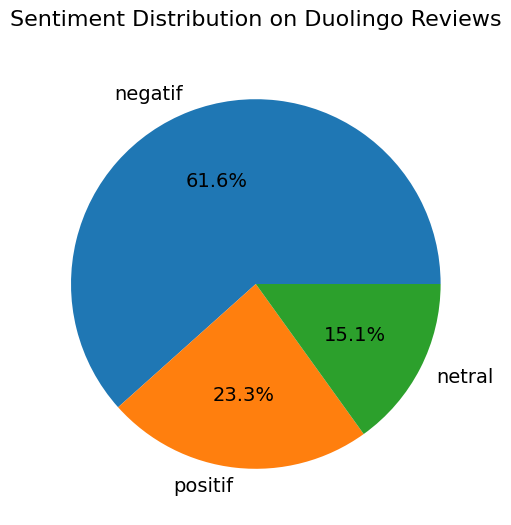

In [16]:
fig, ax = plt.subplots(figsize=(6, 6))
sizes = [count for count in df_cleaned['sentiment'].value_counts()]
labels = list(df_cleaned['sentiment'].value_counts().index)
ax.pie(x=sizes, labels=labels, autopct='%1.1f%%', textprops={'fontsize': 14})
ax.set_title('Sentiment Distribution on Duolingo Reviews', fontsize=16, pad=20)
plt.show()

In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12191 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   rating           12191 non-null  int64 
 1   date             12191 non-null  object
 2   comment          12191 non-null  object
 3   comment_cleaned  12191 non-null  object
 4   sentiment        12191 non-null  object
dtypes: int64(1), object(4)
memory usage: 571.5+ KB


## Feature Engineering

In [18]:
# Definisikan fitur (X) dan label (y)
X = df_cleaned['comment_cleaned']
y = df_cleaned['sentiment']

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(X).toarray()
print(f"Fitur TF-IDF dibuat dengan shape: {X_tfidf.shape}")

# Word2Vec
tokenized_text = [word_tokenize(text) for text in X]
w2v_model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=4)

def document_vector(doc, model):
    doc = [word for word in doc if word in model.wv.index_to_key]
    if not doc: return np.zeros(model.vector_size)
    return np.mean(model.wv[doc], axis=0)

X_w2v = np.array([document_vector(text, w2v_model) for text in tokenized_text])
print(f"Fitur Word2Vec dibuat dengan shape: {X_w2v.shape}")

Fitur TF-IDF dibuat dengan shape: (12191, 5000)
Fitur Word2Vec dibuat dengan shape: (12191, 100)


## Data Splitting

In [19]:
# Split 80/20 (Model 1: SVM-TFIDF, Model 2: RF-Word2Vec)
X_train_tfidf_80, X_test_tfidf_80, y_train_80, y_test_80 = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
X_train_w2v_80, X_test_w2v_80, _, _ = train_test_split(X_w2v, y, test_size=0.2, random_state=42, stratify=y)
print("Split data 80/20 selesai.")

# Split 70/30 (Model 3: RF-TFIDF)
X_train_tfidf_70, X_test_tfidf_70, y_train_70, y_test_70 = train_test_split(X_tfidf, y, test_size=0.3, random_state=42, stratify=y)
print("Split data 70/30 selesai.")

Split data 80/20 selesai.
Split data 70/30 selesai.


## Oversampling (SMOTE)

In [20]:
smote = SMOTE(random_state=42)

# SMOTE pada data 80/20
print("\nDistribusi kelas asli (80/20):", y_train_80.value_counts().to_dict())
X_train_tfidf_80_smote, y_train_80_smote = smote.fit_resample(X_train_tfidf_80, y_train_80)
print("Distribusi kelas setelah SMOTE (TF-IDF 80/20):", y_train_80_smote.value_counts().to_dict())
X_train_w2v_80_smote, _ = smote.fit_resample(X_train_w2v_80, y_train_80)

# SMOTE pada data 70/30
print("\nDistribusi kelas asli (70/30):", y_train_70.value_counts().to_dict())
X_train_tfidf_70_smote, y_train_70_smote = smote.fit_resample(X_train_tfidf_70, y_train_70)
print("Distribusi kelas setelah SMOTE (TF-IDF 70/30):", y_train_70_smote.value_counts().to_dict())


Distribusi kelas asli (80/20): {'negatif': 6009, 'positif': 2273, 'netral': 1470}
Distribusi kelas setelah SMOTE (TF-IDF 80/20): {'negatif': 6009, 'positif': 6009, 'netral': 6009}

Distribusi kelas asli (70/30): {'negatif': 5258, 'positif': 1989, 'netral': 1286}
Distribusi kelas setelah SMOTE (TF-IDF 70/30): {'positif': 5258, 'negatif': 5258, 'netral': 5258}


## Modelling

### Model 1: SVM dengan Fitur TF-IDF (Split 80/20)

In [21]:
from sklearn.metrics import classification_report

results = {}

# Inisialisasi model
svm_model = SVC(kernel='linear', random_state=42)
# Latih model
svm_model.fit(X_train_tfidf_80_smote, y_train_80_smote)
# Lakukan prediksi pada data uji
y_pred_svm = svm_model.predict(X_test_tfidf_80)

# Simpan metrik hasil evaluasi
accuracy_svm = accuracy_score(y_test_80, y_pred_svm)
report_svm = classification_report(y_test_80, y_pred_svm, output_dict=True)
results['SVM (TF-IDF, 80/20)'] = {
    'Akurasi': accuracy_svm,
    'Presisi (Weighted Avg)': report_svm['weighted avg']['precision'],
    'Recall (Weighted Avg)': report_svm['weighted avg']['recall'],
    'F1-Score (Weighted Avg)': report_svm['weighted avg']['f1-score']
}

### Model 2: Random Forest dengan Fitur Word2Vec (Split 80/20)


In [22]:
# Inisialisasi model
rf_w2v_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# Latih model
rf_w2v_model.fit(X_train_w2v_80_smote, y_train_80_smote)
# Lakukan prediksi pada data uji
y_pred_rf_w2v = rf_w2v_model.predict(X_test_w2v_80)

# Simpan metrik hasil evaluasi
accuracy_rf_w2v = accuracy_score(y_test_80, y_pred_rf_w2v)
report_rf_w2v = classification_report(y_test_80, y_pred_rf_w2v, output_dict=True)
results['Random Forest (Word2Vec, 80/20)'] = {
    'Akurasi': accuracy_rf_w2v,
    'Presisi (Weighted Avg)': report_rf_w2v['weighted avg']['precision'],
    'Recall (Weighted Avg)': report_rf_w2v['weighted avg']['recall'],
    'F1-Score (Weighted Avg)': report_rf_w2v['weighted avg']['f1-score']
}

### Model 3: Random Forest dengan Fitur TF-IDF (Split 70/30)


In [23]:
# Inisialisasi model
rf_tfidf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
# Latih model
rf_tfidf_model.fit(X_train_tfidf_70_smote, y_train_70_smote)
# Lakukan prediksi pada data uji
y_pred_rf_tfidf = rf_tfidf_model.predict(X_test_tfidf_70)

# Simpan metrik hasil evaluasi
accuracy_rf_tfidf = accuracy_score(y_test_70, y_pred_rf_tfidf)
report_rf_tfidf = classification_report(y_test_70, y_pred_rf_tfidf, output_dict=True)
results['Random Forest (TF-IDF, 70/30)'] = {
    'Akurasi': accuracy_rf_tfidf,
    'Presisi (Weighted Avg)': report_rf_tfidf['weighted avg']['precision'],
    'Recall (Weighted Avg)': report_rf_tfidf['weighted avg']['recall'],
    'F1-Score (Weighted Avg)': report_rf_tfidf['weighted avg']['f1-score']
}
print("Selesai.")

Selesai.


### Perbandingan Hasil

In [24]:
comparison_df = pd.DataFrame(results).T # Transpose agar nama model menjadi baris

# Format kolom agar lebih mudah dibaca
comparison_df['Akurasi'] = comparison_df['Akurasi'].apply(lambda x: f"{x*100:.2f}%")
comparison_df['Presisi (Weighted Avg)'] = comparison_df['Presisi (Weighted Avg)'].apply(lambda x: f"{x:.2f}")
comparison_df['Recall (Weighted Avg)'] = comparison_df['Recall (Weighted Avg)'].apply(lambda x: f"{x:.2f}")
comparison_df['F1-Score (Weighted Avg)'] = comparison_df['F1-Score (Weighted Avg)'].apply(lambda x: f"{x:.2f}")

# Cetak tabel perbandingan
print("\n\n" + "="*70)
print("           HASIL PERBANDINGAN PERFORMA MODEL")
print("="*70)
print(comparison_df)



           HASIL PERBANDINGAN PERFORMA MODEL
                                Akurasi Presisi (Weighted Avg)  \
SVM (TF-IDF, 80/20)              89.05%                   0.91   
Random Forest (Word2Vec, 80/20)  77.00%                   0.78   
Random Forest (TF-IDF, 70/30)    88.49%                   0.89   

                                Recall (Weighted Avg) F1-Score (Weighted Avg)  
SVM (TF-IDF, 80/20)                              0.89                    0.90  
Random Forest (Word2Vec, 80/20)                  0.77                    0.77  
Random Forest (TF-IDF, 70/30)                    0.88                    0.88  


## Tuning


### Tuning SVM dengan Fitur TF-IDF (Split 80/20)


In [25]:
from sklearn.model_selection import GridSearchCV

tuned_results = {}

param_grid_svm = {'C': [1, 10], 'kernel': ['linear', 'rbf']}
grid_svm = GridSearchCV(SVC(random_state=42), param_grid_svm, cv=3, scoring='f1_weighted', n_jobs=-1, verbose=1)
grid_svm.fit(X_train_tfidf_80_smote, y_train_80_smote)

print(f"Parameter terbaik untuk SVM: {grid_svm.best_params_}")
best_svm = grid_svm.best_estimator_
y_pred_svm_tuned = best_svm.predict(X_test_tfidf_80)

# Simpan hasil tuning
accuracy_svm_tuned = accuracy_score(y_test_80, y_pred_svm_tuned)
report_svm_tuned = classification_report(y_test_80, y_pred_svm_tuned, output_dict=True)
tuned_results['SVM Tuned (TF-IDF, 80/20)'] = {
    'Akurasi': accuracy_svm_tuned,
    'F1-Score (Weighted Avg)': report_svm_tuned['weighted avg']['f1-score'],
    'Parameter Terbaik': str(grid_svm.best_params_)
}

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Parameter terbaik untuk SVM: {'C': 10, 'kernel': 'linear'}


### Tuning Random Forest dengan Fitur Word2Vec (Split 80/20)


In [26]:
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20, None], 'min_samples_leaf': [1, 2]}
grid_rf_w2v = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid_rf, cv=3, scoring='f1_weighted', verbose=1)
grid_rf_w2v.fit(X_train_w2v_80_smote, y_train_80_smote)

print(f"Parameter terbaik untuk RF (Word2Vec): {grid_rf_w2v.best_params_}")
best_rf_w2v = grid_rf_w2v.best_estimator_
y_pred_rf_w2v_tuned = best_rf_w2v.predict(X_test_w2v_80)

# Simpan hasil tuning
accuracy_rf_w2v_tuned = accuracy_score(y_test_80, y_pred_rf_w2v_tuned)
report_rf_w2v_tuned = classification_report(y_test_80, y_pred_rf_w2v_tuned, output_dict=True)
tuned_results['RF Tuned (Word2Vec, 80/20)'] = {
    'Akurasi': accuracy_rf_w2v_tuned,
    'F1-Score (Weighted Avg)': report_rf_w2v_tuned['weighted avg']['f1-score'],
    'Parameter Terbaik': str(grid_rf_w2v.best_params_)
}

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Parameter terbaik untuk RF (Word2Vec): {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}


### Tuning Random Forest dengan Fitur TF-IDF (Split 70/30)


In [27]:
grid_rf_tfidf = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1), param_grid_rf, cv=3, scoring='f1_weighted', verbose=1)
grid_rf_tfidf.fit(X_train_tfidf_70_smote, y_train_70_smote)

print(f"Parameter terbaik untuk RF (TF-IDF): {grid_rf_tfidf.best_params_}")
best_rf_tfidf = grid_rf_tfidf.best_estimator_
y_pred_rf_tfidf_tuned = best_rf_tfidf.predict(X_test_tfidf_70)

# Simpan hasil tuning
accuracy_rf_tfidf_tuned = accuracy_score(y_test_70, y_pred_rf_tfidf_tuned)
report_rf_tfidf_tuned = classification_report(y_test_70, y_pred_rf_tfidf_tuned, output_dict=True)
tuned_results['RF Tuned (TF-IDF, 70/30)'] = {
    'Akurasi': accuracy_rf_tfidf_tuned,
    'F1-Score (Weighted Avg)': report_rf_tfidf_tuned['weighted avg']['f1-score'],
    'Parameter Terbaik': str(grid_rf_tfidf.best_params_)
}

Fitting 3 folds for each of 12 candidates, totalling 36 fits
Parameter terbaik untuk RF (TF-IDF): {'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 200}


### Perbandingan Hasil Tuning

In [28]:
comparison_tuned_df = pd.DataFrame(tuned_results).T

# Format kolom agar lebih mudah dibaca
comparison_tuned_df['Akurasi'] = comparison_tuned_df['Akurasi'].apply(lambda x: f"{x*100:.2f}%")
comparison_tuned_df['F1-Score (Weighted Avg)'] = comparison_tuned_df['F1-Score (Weighted Avg)'].apply(lambda x: f"{x:.2f}")

print("\n\n" + "="*80)
print("           HASIL PERBANDINGAN PERFORMA MODEL SETELAH TUNING")
print("="*80)
print(comparison_tuned_df)



           HASIL PERBANDINGAN PERFORMA MODEL SETELAH TUNING
                           Akurasi F1-Score (Weighted Avg)  \
SVM Tuned (TF-IDF, 80/20)   92.09%                    0.92   
RF Tuned (Word2Vec, 80/20)  77.45%                    0.78   
RF Tuned (TF-IDF, 70/30)    88.38%                    0.88   

                                                            Parameter Terbaik  
SVM Tuned (TF-IDF, 80/20)                       {'C': 10, 'kernel': 'linear'}  
RF Tuned (Word2Vec, 80/20)  {'max_depth': None, 'min_samples_leaf': 1, 'n_...  
RF Tuned (TF-IDF, 70/30)    {'max_depth': None, 'min_samples_leaf': 1, 'n_...  


# Infrence

In [36]:
# Fungsi Prediksi/Inference
def prediksi_sentimen(ulasan_baru):
    if not ulasan_baru.strip():
        print("\nInput tidak boleh kosong. Silakan coba lagi.")
        return

    ulasan_bersih = preprocess_text(ulasan_baru)
    vektor_ulasan = tfidf_vectorizer.transform([ulasan_bersih]).toarray()
    prediksi = best_svm.predict(vektor_ulasan)

    print("-" * 30)
    print(f"Ulasan Anda: \"{ulasan_baru}\"")
    print(f"Hasil Prediksi Sentimen: 🔥 {prediksi[0].upper()} 🔥")
    print("-" * 30)


# Penggunaan Inference
print("\n===== Selamat Datang di Program Prediksi Sentimen Ulasan =====")
print("Ketik ulasan Anda, lalu tekan Enter.")
print("Ketik 'keluar' atau 'exit' untuk berhenti.")

while True:
    # Menerima input dari pengguna
    input_pengguna = input("\nMasukkan ulasan baru: ")

    # Cek kondisi untuk keluar dari loop
    if input_pengguna.lower() in ['keluar', 'exit']:
        print("\nTerima kasih telah menggunakan program ini. Sampai jumpa! 👋")
        break

    # Panggil fungsi prediksi
    prediksi_sentimen(input_pengguna)


===== Selamat Datang di Program Prediksi Sentimen Ulasan =====
Ketik ulasan Anda, lalu tekan Enter.
Ketik 'keluar' atau 'exit' untuk berhenti.

Masukkan ulasan baru: Duolingo belum bisa membantu saya dalam pembelajaran bahasa asing
------------------------------
Ulasan Anda: "Duolingo belum bisa membantu saya dalam pembelajaran bahasa asing"
Hasil Prediksi Sentimen: 🔥 NEGATIF 🔥
------------------------------

Masukkan ulasan baru: exit

Terima kasih telah menggunakan program ini. Sampai jumpa! 👋
